#  **Diabetic Retinopathy Detection 3540 Images**

In this notebook, we work with a dataset of approximately 3,540 images. The dataset was carefully balanced to ensure an equal number of images across all 5 classes. This balance improves the performance of the quinary classification by providing a more evenly distributed dataset.

Here, we focused solely on training models for the multiclass classification to evaluate whether using a balanced dataset improves performance. As expected, binary classification yielded poor results on this dataset, so it was excluded from our analysis.

# **1. Imports**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torch.nn.functional as F
import numpy as np
import tensorflow as tf
import seaborn as sns
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import threading
import time
import torchvision.models as models
import torch.optim as optim
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from torch import nn, optim
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.image import resize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import DataLoader

from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **2. Loading Data and EDA**

We create a dataframe containing:
- the image name;
- the path to the image;
- a variable specifying if the eye is the right one (0) or the left one (1);
- the label specifying the level of the retinopathy desease (0 to 4);
- the patient ID.

In [ ]:
base_image_dir = os.path.join('..', '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/DATA_3K')
retina_df = pd.read_csv(os.path.join('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/', 'trainLabels.csv'))

retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, '{}.jpeg'.format(x)))

retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

retina_df = retina_df[retina_df['exists']]
retina_df

3540 images found of 35126 total


,image,level,PatientId,path,exists,eye
6,16_left,4,16,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
7,16_right,4,16,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0
80,79_left,2,79,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
90,99_left,3,99,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
114,129_left,2,129,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
...,...,...,...,...,...,...
35048,44249_left,4,44249,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
35049,44249_right,4,44249,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0
35072,44275_left,1,44275,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
35098,44323_left,1,44323,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1


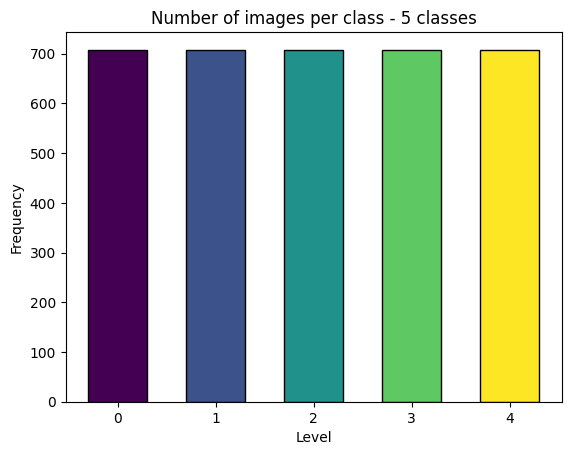

In [ ]:
bins = range(int(retina_df["level"].min()), int(retina_df["level"].max()) + 2)

counts, bins, patches = plt.hist(retina_df["level"], bins=bins, edgecolor='black', rwidth=0.6)

bin_centers = [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)]
plt.xticks(bin_centers, [str(int(bin_center - 0.5)) for bin_center in bin_centers])

colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.xlabel('Level')
plt.ylabel('Frequency')
plt.title('Number of images per class - 5 classes')

plt.show()

Here we don't perform binary classification. <br>
However, we decided anyways to add a binary label:
- 0 indicates that the patient is healthy
- 1 indicates the presence of diabetic retinopathy (DR)

This will be used to see the balance between "healthy" and "non-healthy" and not for any classification purposes.

In [ ]:
retina_df['binary_level'] = retina_df['level'].apply(lambda x: 0 if x == 0 else 1)

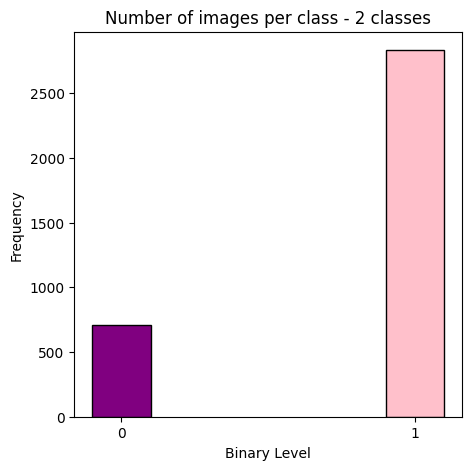

In [ ]:
bins = [0, 1, 2]

fig, ax = plt.subplots(figsize=(5, 5))
counts, bins, patches = ax.hist(retina_df['binary_level'], bins=bins, edgecolor='black', rwidth=0.2, align='mid')

ax.set_xticks([0.5, 1.5])
ax.set_xticklabels([0, 1])

colors = ['purple', 'pink']
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

ax.set_xlabel('Binary Level')
ax.set_ylabel('Frequency')
ax.set_title('Number of images per class - 2 classes')

plt.show()

In [ ]:
retina_df

,image,level,PatientId,path,exists,eye,level_cat,binary_level
6,16_left,4,16,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 0, 0, 1]",1
7,16_right,4,16,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[0, 0, 0, 0, 1]",1
80,79_left,2,79,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 1, 0, 0]",1
90,99_left,3,99,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 0, 1, 0]",1
114,129_left,2,129,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 1, 0, 0]",1
...,...,...,...,...,...,...,...,...
35048,44249_left,4,44249,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 0, 0, 1]",1
35049,44249_right,4,44249,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[0, 0, 0, 0, 1]",1
35072,44275_left,1,44275,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 1, 0, 0, 0]",1
35098,44323_left,1,44323,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 1, 0, 0, 0]",1


# **3. Preprocessing**

We preprocessed the images using OpenCV package to:  

1. rescale the images to have the same radius (300 pixels),  

2. subtracted the local average color that gets mapped to 50% gray,  

3. clipped the images to 90% size to remove the boundary effects (the black background around the eye).


First we tried to preprocess one image, then we make a loop to preprocess all images.

In [ ]:
def scaleRadius(img, scale):
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    s = scale * 1.0 / r
    return cv2.resize(img, (0, 0), fx=s, fy=s)

scale = 300

for f in glob.glob(base_image_dir):
    try:
        a = cv2.imread(f)
        a = scaleRadius(a, scale)

        a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0, 0), scale/30), -4, 128)

        b = np.zeros(a.shape)
        cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(scale * 0.9), (1, 1, 1), -1, 8, 0)
        a = a * b + 128 * (1 - b) # a = a * b black

        output_file_path = os.path.join(output_path, os.path.basename(f))

        cv2.imwrite(output_file_path, a)
    except Exception as e:
        print(f, e)

# **4. Models' Setup**

We define a function set_seed to set the random seed. This ensures that our experiments are reproducible.

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

We define a series of transformations to be applied to the images. These transformations include resizing the images to 224x224 pixels, converting the images to PyTorch tensors, and normalizing the images with specific mean and standard deviation values calculated for our dataset.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5025, 0.5015, 0.5012], std=[0.0531, 0.0581, 0.0388])
])

These functions handle the image loading and transformation, returning the processed image tensors along with their labels.

In [ ]:
def load_5(row):
    image_path = row['path']
    if os.path.exists(image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        return image_tensor, row['level']
    return None

These functions utilize multithreading to efficiently load and transform the images, returning lists of image tensors and labels.

In [ ]:
def create_tensors_5(df):
    image_tensors = []
    labels = []
    with ThreadPoolExecutor() as executor:
        results = executor.map(load_5, [row for _, row in df.iterrows()])
        for result in results:
            if result is not None:
                image_tensor, label = result
                image_tensors.append(image_tensor)
                labels.append(label)
    return image_tensors, labels

Next, we create tensors for 5-class classification. This section prints the shapes of the resulting tensors to verify the data processing.

In [ ]:
image_tensors_5, labels_5 = create_tensors_5(retina_df)

images_tensor_5 = torch.stack(image_tensors_5)
labels_tensor_5 = torch.tensor(labels_5, dtype=torch.long)
print(f"Total images 5 classes: {images_tensor_5.shape}")
print(f"Total labels 5 classes: {labels_tensor_5.shape}")

Total images 5 classes: torch.Size([3540, 3, 224, 224])
Total labels 5 classes: torch.Size([3540])


In [ ]:
class RetinaDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

This custom dataset class is essential for using the DataLoader in PyTorch, allowing for easy batching and shuffling of the data.

This next cell splits the 5-classes image tensors and labels into training and testing sets, creates the dataset and DataLoader, and prints the shape of the first batch from the training DataLoader.

In [ ]:
train_images_5, test_images_5, train_labels_5, test_labels_5 = train_test_split(images_tensor_5, labels_tensor_5, test_size=0.3, random_state=42)

train_dataset_5 = RetinaDataset(train_images_5, train_labels_5)
test_dataset_5 = RetinaDataset(test_images_5, test_labels_5)

train_loader_5 = DataLoader(train_dataset_5, batch_size=10, shuffle=True)
test_loader_5 = DataLoader(test_dataset_5, batch_size=10, shuffle=False)

for images, labels in train_loader_5:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([10, 3, 224, 224])
Batch of labels shape: torch.Size([10])


# **5. VGG16 model - 5 Classes**

In this section, we adapt the VGG16 model for multi-class classification, where the task is to classify images into one of five distinct classes. Similar to the binary classifier, the VGG16 model is pre-trained, and its classifier head is replaced with a custom architecture. This custom head includes a linear layer followed by a ReLU activation, dropout for regularization, and a final linear layer with a Softmax activation to output probabilities for each of the five classes. The model is trained using Cross Entropy Loss and optimized with SGD.




In [ ]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16_5 = models.vgg16(pretrained=True)
for param in vgg16_5.features.parameters():
    param.requires_grad = False

vgg16_5.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
    nn.Softmax(dim=1)
)

vgg16_5 = vgg16_5.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Early stopping is also implemented here to avoid overfitting, with a patience of 3 epochs. A ReduceLROnPlateau scheduler dynamically adjusts the learning rate based on validation loss improvements.


We record and plot training and validation losses to assess the model's learning trajectory.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, 
 Loss: 1.5041935910140314, Accuracy: 0.36642453591606133
Validation Loss: 1.5123392399226394, Validation Accuracy: 0.3512241054613936
Epoch 2, 
 Loss: 1.4990687226095507, Accuracy: 0.37691686844229216
Validation Loss: 1.5109640137057438, Validation Accuracy: 0.3418079096045198
Epoch 3, 
 Loss: 1.4935822179240565, Accuracy: 0.3870056497175141
Validation Loss: 1.5098773385876807, Validation Accuracy: 0.3483992467043315
Epoch 4, 
 Loss: 1.4929194152355194, Accuracy: 0.3833736884584342
Validation Loss: 1.5087835476777265, Validation Accuracy: 0.3512241054613936
Epoch 5, 
 Loss: 1.4853057933430518, Accuracy: 0.39709443099273606
Validation Loss: 1.5074670916405795, Validation Accuracy: 0.3483992467043315
Epoch 6, 
 Loss: 1.4916705383408455, Accuracy: 0.3894269572235674
Validation Loss: 1.505610922786677, Validation Accuracy: 0.3531073446327684
Epoch 7, 
 Loss: 1.489067296827993, Accuracy: 0.38054882970137205
Validation Loss: 1.5057346709420747, Validation Accuracy: 0.34557438794726

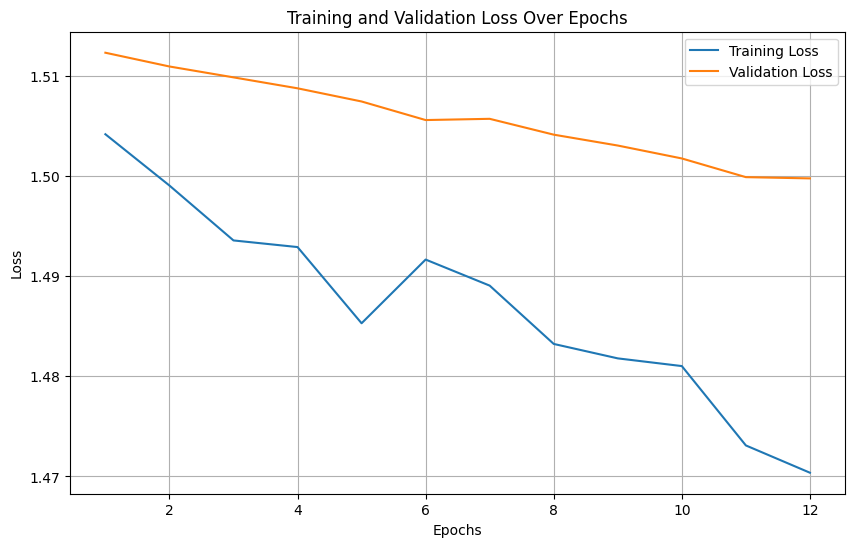

In [ ]:
criterion_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(vgg16_5.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

scheduler_5 = ReduceLROnPlateau(optimizer_5, mode='min', factor=0.1, patience=2, verbose=True)

patience_5 = 3
early_stopping_counter_5 = 0
previous_val_loss_5 = float('inf')

train_losses_v_5 = []
val_losses_v_5 = []
train_accuracies_v_5 = []
val_accuracies_v_5 = []

for epoch in range(12):
    vgg16_5.train()
    running_loss_5 = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        optimizer_5.zero_grad()
        outputs = vgg16_5(images)
        outputs = outputs.squeeze(dim=1)
        loss = criterion_5(outputs, labels)
        loss.backward()
        optimizer_5.step()
        running_loss_5 += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)


    train_accuracy_5 = correct_train / total_train
    train_loss_5 = running_loss_5 / len(train_loader_5)
    train_accuracies_v_5.append(train_accuracy_5)
    train_losses_v_5.append(train_loss_5)
    print(f"Epoch {epoch+1}, \n Loss: {train_loss_5}, Accuracy: {train_accuracy_5}")


    vgg16_5.eval()
    val_loss_5 = 0.0
    val_accuracy_5 = 0.0
    val_loss_5 = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16_5(images)
            outputs = outputs.squeeze(dim=1)
            loss = criterion_5(outputs, labels)
            val_loss_5 += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss_5 = val_loss_5 / len(test_loader_5)
    val_accuracy_5 = correct_val / total_val
    val_losses_v_5.append(val_loss_5)
    val_accuracies_v_5.append(val_accuracy_5)
    print(f"Validation Loss: {val_loss_5}, Validation Accuracy: {val_accuracy_5}")

    scheduler_5.step(val_loss_5)

    if val_loss_5 < previous_val_loss_5:
        previous_val_loss_5 = val_loss_5
        early_stopping_counter_5 = 0
    else:
        early_stopping_counter_5 += 1
        if early_stopping_counter_5 >= patience_5:
            print("Early stopping triggered")
            break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_v_5) + 1), train_losses_v_5, label='Training Loss')
plt.plot(range(1, len(val_losses_v_5) + 1), val_losses_v_5, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

 The training and validation losses decrease over epochs, showing that the model is learning. However, the losses remain high, reflecting the increased difficulty of the 5-class classification task compared to binary classification.

Performance evaluation is done by calculating accuracy on the training and test sets and generating a confusion matrix to provide insights into the classification accuracy across different classes.

In [ ]:
vgg16_5.eval()
with torch.no_grad():
    correct_5, total_5 = 0, 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_5(images)
        _, predicted = torch.max(outputs, 1)
        total_5 += labels.size(0)
        correct_5 += (predicted == labels).sum().item()
    final_train_acc_5 = correct_5 / total_5
    print("Training accuracy:", final_train_acc_5 * 100)

with torch.no_grad():
    correct_5, total_5 = 0, 0
    all_preds_5 = []
    all_labels_5 = []
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_5(images)
        _, predicted = torch.max(outputs, 1)
        total_5 += labels.size(0)
        correct_5 += (predicted == labels).sum().item()
        all_preds_5.extend(predicted.cpu().numpy())
        all_labels_5.extend(labels.cpu().numpy())
    test_acc_5 = correct_5 / total_5
    print("Test accuracy:", test_acc_5 * 100)

Training accuracy: 32.36481033091202
Test accuracy: 31.26177024482109


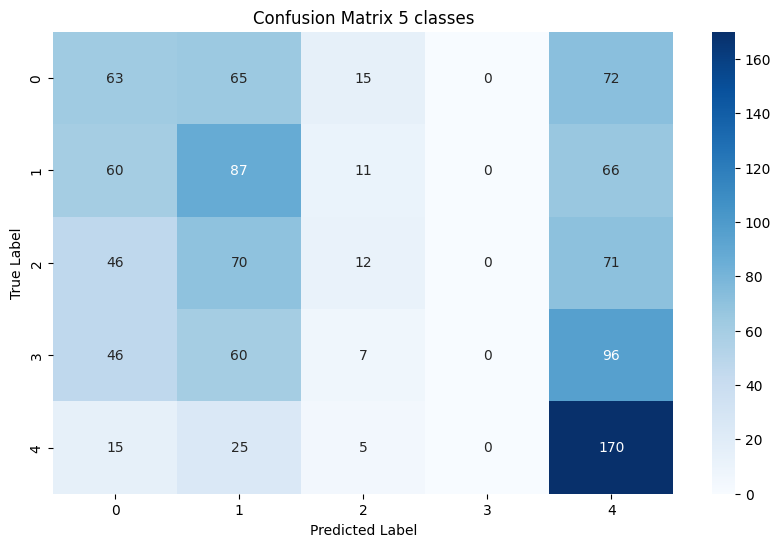

In [ ]:
cm_5 = confusion_matrix(all_labels_5, all_preds_5)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_5, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix 5 classes')
plt.show()

The results indicate that while the model performs reasonably well for certain classes (e.g., class 4), there is significant confusion among other classes (e.g., classes 1, 2, and 3).

This could be attributed to the complexity of multi-class
classification, model suitability (VGG16, although powerful, might be more effective for binary classification tasks or tasks with fewer classes) and an insufficient number of images.

In [ ]:
model_save_path = '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/vgg16_5_classes_classification.pth'
torch.save(vgg16_5.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/vgg16_5_classes_classification.pth


# **6. AlexNet - 5 Classes**

Here we use the pre-trained AlexNet model for multi-class classification, where the task is to classify images into one of five distinct classes. The model's classifier head is replaced with a custom architecture, which includes a linear layer followed by a ReLU activation, dropout for regularization, and a final linear layer. The model is trained using Cross Entropy Loss and optimized with SGD.

In [ ]:
set_seed(42)

alexnet = models.alexnet(pretrained=True)
for param in alexnet.features.parameters():
    param.requires_grad = False

alexnet.classifier[6] = nn.Sequential(
    nn.Linear(alexnet.classifier[6].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 218MB/s]


Early stopping is also implemented here to avoid overfitting, with a patience of 3 epochs. A ReduceLROnPlateau scheduler dynamically adjusts the learning rate based on validation loss improvements.

In [ ]:
criterion_a_5 = nn.CrossEntropyLoss()
optimizer_a_5 = optim.Adam(alexnet.parameters(), lr=0.0001)
scheduler_a_5 = ReduceLROnPlateau(optimizer_a_5, 'min', patience=3, verbose=True)

num_epochs = 10
train_losses_a_5 = []
train_accuracies_a_5 = []
test_losses_a_5 = []
test_accuracies_a_5 = []

best_test_loss_a_5 = float('inf')
patience_a_5 = 3
trigger_times_a_5 = 0

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)

        optimizer_a_5.zero_grad()

        outputs = alexnet(images)
        loss = criterion_a_5(outputs, labels)

        loss.backward()
        optimizer_a_5.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader_5.dataset)
    epoch_accuracy = correct / total
    train_losses_a_5.append(epoch_loss)
    train_accuracies_a_5.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    scheduler_a_5.step(epoch_loss)

    alexnet.eval()
    test_running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet(images)
            loss = criterion_a_5(outputs, labels)
            test_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    test_loss = test_running_loss / len(test_loader_5.dataset)
    test_accuracy = correct / total
    test_losses_a_5.append(test_loss)
    test_accuracies_a_5.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    if test_loss < best_test_loss_a_5:
        best_test_loss_a_5 = test_loss
        trigger_times_a_5 = 0
    else:
        trigger_times_a_5 += 1
        if trigger_times_a_5 >= patience_a_5:
            print(f"Early stopping at epoch {epoch+1}")
            break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10, Loss: 1.4877, Accuracy: 0.3123
Test Loss: 1.4088, Test Accuracy: 0.3701
Epoch 2/10, Loss: 1.3854, Accuracy: 0.3769
Test Loss: 1.3848, Test Accuracy: 0.3804
Epoch 3/10, Loss: 1.3083, Accuracy: 0.4173
Test Loss: 1.3983, Test Accuracy: 0.3606
Epoch 4/10, Loss: 1.2386, Accuracy: 0.4330
Test Loss: 1.3664, Test Accuracy: 0.4030
Epoch 5/10, Loss: 1.1757, Accuracy: 0.4835
Test Loss: 1.3561, Test Accuracy: 0.4087
Epoch 6/10, Loss: 1.0928, Accuracy: 0.5315
Test Loss: 1.4668, Test Accuracy: 0.4218
Epoch 7/10, Loss: 1.0479, Accuracy: 0.5468
Test Loss: 1.3946, Test Accuracy: 0.4124
Epoch 8/10, Loss: 0.9505, Accuracy: 0.6029
Test Loss: 1.4651, Test Accuracy: 0.3879
Early stopping at epoch 8


In [ ]:
alexnet.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    final_train_acc_a_5 = correct / total
    print("Training accuracy:", final_train_acc_a_5 * 100)

all_preds_a_5 = []
all_labels_a_5 = []
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds_a_5.extend(preds.cpu().numpy().tolist())
        all_labels_a_5.extend(labels.cpu().numpy().tolist())
    test_acc_a_5 = correct / total
    print("Test accuracy:", test_acc_a_5 * 100)

Training accuracy: 76.43260694108152
Test accuracy: 38.79472693032015


We plot training and test loss over epochs to see whether the model effectively learns how to classify our data over epochs.

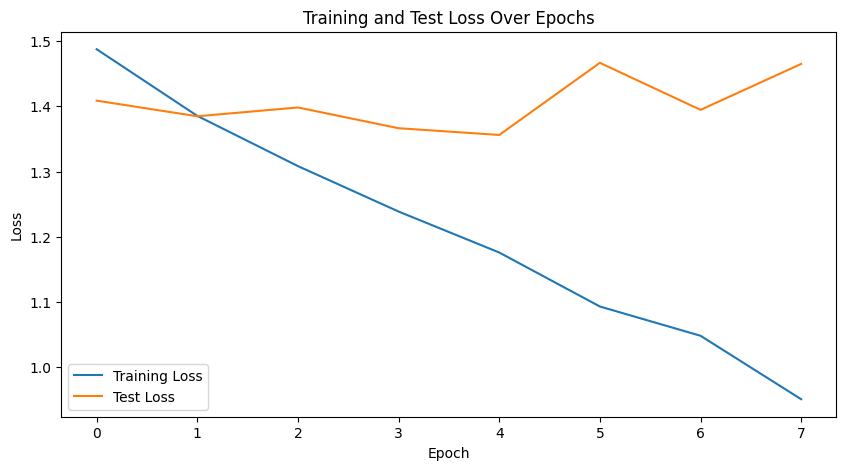

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_a_5, label='Training Loss')
plt.plot(test_losses_a_5, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

We see that, while the training loss decreases, the validation loss fluctuates and ends up being even higher. <br>
Moreover, looking at the resulting accuracies, we notice that our model has a training accuracy way higher than the testing one, which indicates a high risk of overfitting. <br>
Let's plot the confusion matrix.

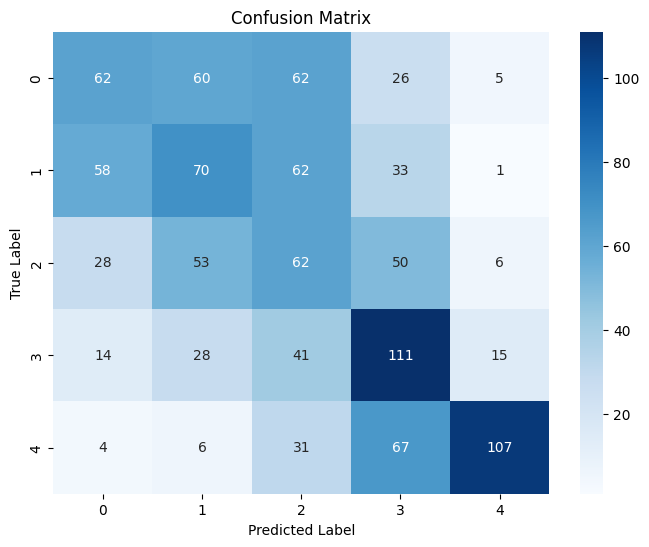

In [ ]:
cm_a_5 = confusion_matrix(all_labels_a_5, all_preds_a_5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_a_5, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Overall, our confusion matrix doesn't show bad results: we notice that even if many images are misclassified, most of them are still classified in the "neighbouring" areas of the right class (meaning, most of the misclassification of class 1 for example, end up being classified as 0s or 2s). <br>
Therefore, even if AlexNet model has a risk of overfitting, we ended up with a pretty satisfactory classification with almost 40% accuracy over 5 classes.

In [ ]:
model_save_path = '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/alexnet_5_classes_classification.pth'
torch.save(alexnet.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/alexnet_5_classes_classification.pth


# **7. GoogleLeNet - 5 Classes**


In this section, we employ a pre-trained GoogleLeNet model for a multiclass classification task with five classes. The model's final fully connected layer is replaced with a custom classifier head, consisting of two linear layers separated by ReLU activation and dropout for regularization, followed by a softmax activation to output class probabilities.

In [ ]:
set_seed(42)
googlenet = models.googlenet(pretrained=True)
for param in googlenet.parameters():
    param.requires_grad = False

googlenet.fc = nn.Sequential(
    nn.Linear(googlenet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
    nn.Softmax(dim=1)
)

googlenet = googlenet.to(device)

criterion_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(googlenet.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler_5 = ReduceLROnPlateau(optimizer_5, mode='min', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 190MB/s]


We iterated over the dataset for 12 epochs, adjusting model parameters based on backpropagation. Doing so, we monitored training and validation loss and accuracy, implementing early stopping to prevent overfitting.
The results are then visualized through loss curves.

Epoch 1, Loss: 1.6098037297154166, Accuracy: 0.18926553672316385
Validation Loss: 1.6093331195989347, Accuracy: 0.2005649717514124
Epoch 2, Loss: 1.6088468433869665, Accuracy: 0.2062146892655367
Validation Loss: 1.6090765073474518, Accuracy: 0.1958568738229755
Epoch 3, Loss: 1.6077759148518438, Accuracy: 0.2247780468119451
Validation Loss: 1.6086956451168168, Accuracy: 0.19868173258003766
Epoch 4, Loss: 1.6082487542173187, Accuracy: 0.211864406779661
Validation Loss: 1.6081965876613409, Accuracy: 0.20338983050847456
Epoch 5, Loss: 1.6077314186134677, Accuracy: 0.22800645682001613
Validation Loss: 1.607869508800758, Accuracy: 0.20998116760828625
Epoch 6, Loss: 1.6065412335476632, Accuracy: 0.2360774818401937
Validation Loss: 1.6074815959355702, Accuracy: 0.2165725047080979
Epoch 7, Loss: 1.6070556900403112, Accuracy: 0.2247780468119451
Validation Loss: 1.6069640370187561, Accuracy: 0.22504708097928436
Epoch 8, Loss: 1.6065725063103837, Accuracy: 0.22276029055690072
Validation Loss: 1.60

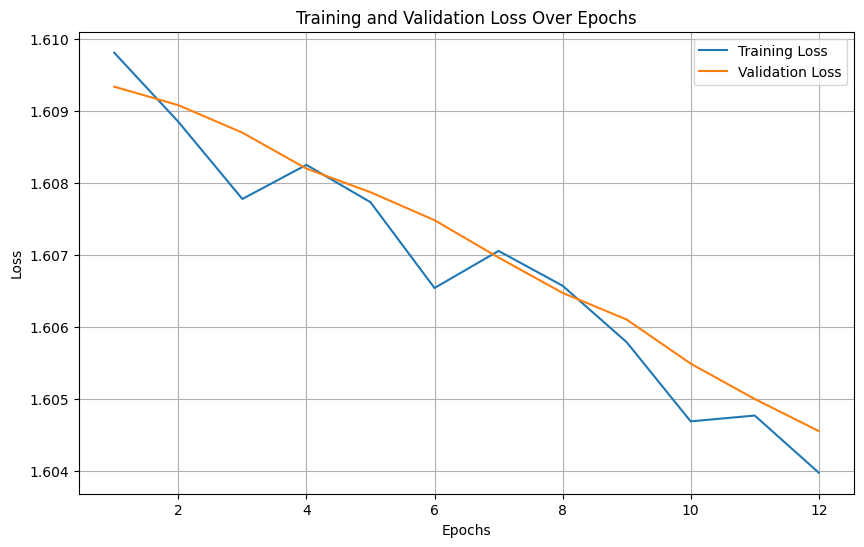

In [ ]:
patience_5 = 3
early_stopping_counter_5 = 0
previous_val_loss_5 = float('inf')

train_losses_5 = []
val_losses_5 = []
train_accuracies_5 = []
val_accuracies_5 = []

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data)
    return corrects.double() / labels.size(0)

for epoch in range(12):
    googlenet.train()
    running_loss_5 = 0.0
    running_corrects_5 = 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        optimizer_5.zero_grad()
        outputs = googlenet(images)
        loss = criterion_5(outputs, labels)
        loss.backward()
        optimizer_5.step()
        running_loss_5 += loss.item() * images.size(0)
        running_corrects_5 += torch.sum(torch.max(outputs, 1)[1] == labels.data)

    train_loss_5 = running_loss_5 / len(train_loader_5.dataset)
    train_accuracy_5 = running_corrects_5.double() / len(train_loader_5.dataset)
    train_losses_5.append(train_loss_5)
    train_accuracies_5.append(train_accuracy_5)
    print(f"Epoch {epoch+1}, Loss: {train_loss_5}, Accuracy: {train_accuracy_5}")

    googlenet.eval()
    val_loss_5 = 0.0
    val_corrects_5 = 0
    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion_5(outputs, labels)
            val_loss_5 += loss.item() * images.size(0)
            val_corrects_5 += torch.sum(torch.max(outputs, 1)[1] == labels.data)

    val_loss_5 /= len(test_loader_5.dataset)
    val_accuracy_5 = val_corrects_5.double() / len(test_loader_5.dataset)
    val_losses_5.append(val_loss_5)
    val_accuracies_5.append(val_accuracy_5)
    print(f"Validation Loss: {val_loss_5}, Accuracy: {val_accuracy_5}")

    scheduler_5.step(val_loss_5)

    if val_loss_5 < previous_val_loss_5:
        previous_val_loss_5 = val_loss_5
        early_stopping_counter_5 = 0
    else:
        early_stopping_counter_5 += 1
        if early_stopping_counter_5 >= patience_5:
            print("Early stopping triggered")
            break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_5) + 1), train_losses_5, label='Training Loss')
plt.plot(range(1, len(val_losses_5) + 1), val_losses_5, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

As it can be seen from the graphs above and from the confusion matrix below, the model effectively learns features from the data. However, we have an high percentage of misclassified images, which means that the model could be fine-tuned in order to achieve better results. This is, nevertheless, a satisfactory result that proves the effectiveness of GoogleLeNet in this specific classification task and that proves our idea that the unbalanced data caused the model to not learn effectively the features of the images.

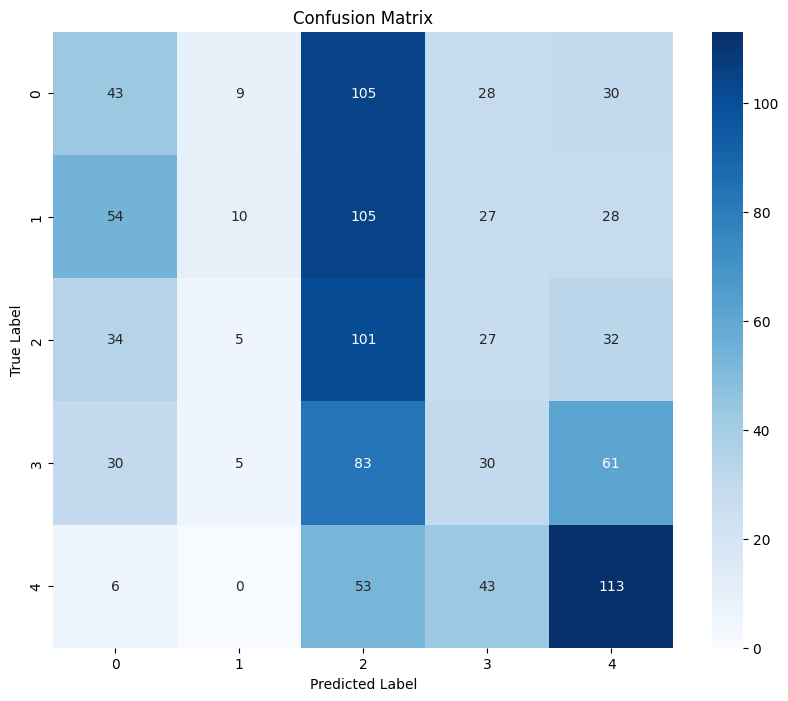

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_save_path = '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/google_5_classes_classification.pth'
torch.save(googlenet.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/google_5_classes_classification.pth


# **8. ResNet - 5 Classes**

This section utilizes the same model employed for classification on the unbalanced dataset.

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tqdm import tqdm

import psutil
import threading
import time

from google.colab import drive
drive.mount('/content/drive')

def build_and_compile_model(input_shape, num_classes):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output_layer)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return model

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

def create_dataframe(df, source_folder):
    df['image_path'] = df['image'].map(lambda x: os.path.join(source_folder, f"{x}.jpeg"))
    return df

def data_generator(df, batch_size, num_classes):
    while True:
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]

            images = []
            labels = []
            for _, row in batch_df.iterrows():
                img_path = row['image_path']
                if os.path.exists(img_path):
                    img = preprocess_image(img_path)
                    images.append(img)
                    label = tf.keras.utils.to_categorical(row['level'], num_classes)
                    labels.append(label)

            if len(images) > 0:
                yield np.array(images), np.array(labels)

def count_elements(df, val):
    count = df['level'].value_counts().loc[[val]].get(val, 0)
    return count

if __name__ == '__main__':
    print("Starting the program...")
    print("Creating the model...")
    model = build_and_compile_model((224, 224, 3), 5)

    source_folder = '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/DATA_3K'
    df = pd.read_csv('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/trainLabels.csv')

    df = create_dataframe(df, source_folder)

    df_train_val, df_test = train_test_split(df, test_size=0.15, random_state=42)
    df_train, df_valid = train_test_split(df_train_val, test_size=0.05, random_state=42)

    batch_size = 32

    train_generator = data_generator(df_train, batch_size, 5)
    valid_generator = data_generator(df_valid, batch_size, 5)
    test_generator = data_generator(df_test, batch_size, 5)

    steps_per_epoch = len(df_train) // batch_size
    validation_steps = len(df_valid) // batch_size
    test_steps = len(df_test) // batch_size

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint("model_eye.keras", verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1)
    csv_log = CSVLogger("log.csv", append=True)

    callbacks = [early_stopping, checkpoint, reduce_lr, csv_log]

    print("Training the model...")
    history = model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=valid_generator,
                        validation_steps=validation_steps,
                        epochs=10,
                        callbacks=callbacks)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting the program...
Creating the model...
Training the model...
Epoch 1/10
886/886 [==============================] - ETA: 0s - loss: 1.7128 - accuracy: 0.2262
Epoch 1: val_loss improved from inf to 1.61165, saving model to model_eye.keras
886/886 [==============================] - 2007s 2s/step - loss: 1.7128 - accuracy: 0.2262 - val_loss: 1.6116 - val_accuracy: 0.1679 - lr: 0.0010
Epoch 2/10
886/886 [==============================] - ETA: 0s - loss: 1.7071 - accuracy: 0.2397
Epoch 2: val_loss did not improve from 1.61165
886/886 [==============================] - 81s 92ms/step - loss: 1.7071 - accuracy: 0.2397 - val_loss: 2.3731 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 3/10
886/886 [==============================] - ETA: 0s - loss: 1.6939 - accuracy: 0.2210
Epoch 3: val_loss did not improve from 1.61165
886/886 [==============================] - 80s 90

In [ ]:
    save_dir = '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED'
    os.makedirs(save_dir, exist_ok=True)

    print("Saving the final model...")
    model_path = os.path.join(save_dir, "ResNet_model_3K_quinary.keras")
    model.save(model_path)
    print(f"Model saved to: {model_path}")

    print("Evaluating the model on test data...")
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

Saving the final model...
Model saved to: /content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/ResNet_model_3K_quinary.keras
Evaluating the model on test data...
164/164 [==============================] - 398s 2s/step - loss: 1.6441 - accuracy: 0.2476
Test Loss: 1.644092321395874
Test Accuracy: 0.24761904776096344


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.show()

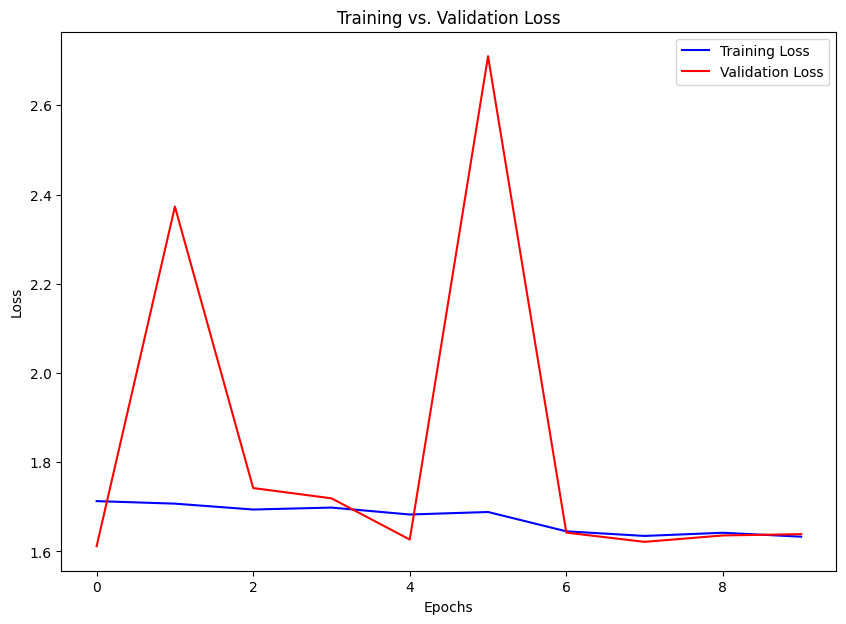

1/1 [==============================] - 0s 46ms/step


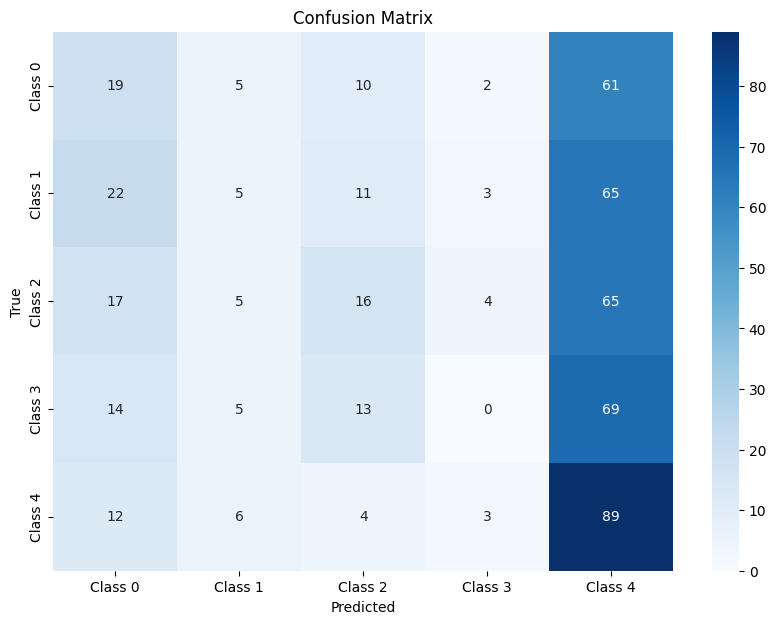

In [ ]:
plot_training_history(history)

y_true = []
y_pred = []
for _ in range(len(df_test) // batch_size):
    images, labels = next(test_generator)
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

plot_confusion_matrix(y_true, y_pred, classes=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])



The confusion matrix reveals a significant issue with the classifier’s performance, as it appears that the model has a bias towards predicting all instances as class 4. Some observations:

*   The model has a strong tendency to classify instances as Class 4, which may indicate a bias or an imbalance in the dataset towards Class 4.
*   Classes 0, 1, 2, and 3 are frequently misclassified as Class 4, suggesting the model struggles to differentiate between these classes.
*   Class 3 has the poorest performance, with no correct classifications and a high rate of misclassification as Class 4.
*  There is some level of confusion among Classes 0, 1, and 2, but the most significant misclassification occurs towards Class 4.

Overall, this confusion matrix indicates that the classifier has a predominant tendency to classify nearly all instances as class 4, regardless of their true labels.


# **9. Random Model - 5 Classes**


In this section, we performed 5 class classifications using a random model.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

num_classes = 5

correct_random_train = 0
total_random_train = 0
for images, labels in train_loader_5:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_train += labels.size(0)
    correct_random_train += (predicted == labels).sum().item()

train_acc_random = correct_random_train / total_random_train
print("Random model training accuracy:", train_acc_random * 100)

correct_random_test = 0
total_random_test = 0
all_preds_random = []
all_labels_random = []
for images, labels in test_loader_5:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_test += labels.size(0)
    correct_random_test += (predicted == labels).sum().item()
    all_preds_random.extend(predicted.cpu().numpy())
    all_labels_random.extend(labels.cpu().numpy())

test_acc_random = correct_random_test / total_random_test
print("Random model test accuracy:", test_acc_random * 100)

Random model training accuracy: 20.581113801452787
Random model test accuracy: 19.397363465160076


The comparative analysis shows that the pre-trained models for 5 class classification, despite their flaws, perform significantly better than this random model.

The trained models demonstrate better learning, higher accuracy, and less randomness.

# **10. Ensembling**

Next, we perform ensembling to improve the accuracy and robustness of models by combining predictions from multiple of them. We use the models trained for 5-classes classification as we mainly aim to improve it in this balanced dataset.

In [ ]:
googlenet.load_state_dict(torch.load('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/google_5_classes_classification.pth'))
googlenet.to(device)
googlenet.eval()

alexnet.load_state_dict(torch.load('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/alexnet_5_classes_classification.pth'))
alexnet.to(device)
alexnet.eval()

vgg16_5.load_state_dict(torch.load('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/vgg16_5_classes_classification.pth'))
vgg16_5.to(device)
vgg16_5.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
test_loader_5 = DataLoader(test_dataset_5, batch_size=32, shuffle=False)

vgg_preds = []
alexnet_preds = []
googlenet_preds = []

with torch.no_grad():
    for images, _ in test_loader_5:
        images = images.to(device)

        outputs_v = vgg16_5(images)
        preds_v = torch.sigmoid(outputs_v).cpu().numpy()
        vgg_preds.append(preds_v)

        outputs_a = alexnet(images)
        preds_a = torch.sigmoid(outputs_a).cpu().numpy()
        alexnet_preds.append(preds_a)

        outputs_g = googlenet(images)
        preds_g = torch.sigmoid(outputs_g).cpu().numpy()
        googlenet_preds.append(preds_g)

vgg_preds = np.concatenate(vgg_preds, axis=0)
alexnet_preds = np.concatenate(alexnet_preds, axis=0)
googlenet_preds = np.concatenate(googlenet_preds, axis=0)


In [ ]:
ensemble_preds = (googlenet_preds + alexnet_preds + vgg_preds) / 3.0

In [ ]:
ensemble_preds = ensemble_preds.argmax(axis=1)
true_labels = test_dataset_5.labels

ensemble_accuracy = accuracy_score(true_labels, ensemble_preds)
print(f'Ensemble Accuracy: {ensemble_accuracy:.4f}')


Ensemble Accuracy: 0.4021


The ensemble accuracy is satisfactory and it's the highest one so far for the 5-classes classification, making this our best model. As can be seen from the confusion matrix, we get improved classification.

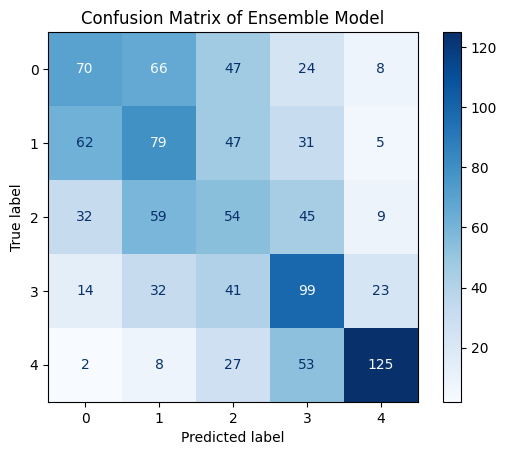

In [ ]:
cm = confusion_matrix(true_labels, ensemble_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Ensemble Model')
plt.show()